In [1]:
import urllib.request
import os
import tarfile

#下载数据集
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-pyhton.tar.gz'
filepath = 'data/cifar-10-python.tar.gz'
if not os.path.isfile(filepath):
    result = urllib.request.urlretrieve(url,filepath)
    print('downloaded',result)
else:
    print('data dile already exist')
    
#解压文件
if not os.path.exists('data/cifar-10-batches-py'):
    tfile = tarfile.open(filepath,'r:gz')
    result = tfile.extractall('data/')
    print('extracted to ./data/cifar-10-batches-py/')
else:
    print('diretory already exists')

data dile already exist
diretory already exists


In [2]:
import numpy as np
import pickle as p
def load_cifar_batch(filename):
    #读取一个batch的内容
    with open(filename,'rb') as f:
        #样本由标签和图像数据组成
        #<1xlabel>,<32x32x3xpixel>
        data_dict = p.load(f,encoding = 'bytes')
        images = data_dict[b'data']
        labels = data_dict[b'labels']
        images = images.reshape(10000,3,32,32)
        images = images.transpose(0,2,3,1)
        labels = np.array(labels)
        return images,labels

In [3]:
def load_cifar_data(data_dir):
    images_train = []
    labels_train = []
    for i in range(5):
        f = os.path.join(data_dir,'data_batch_%d'%(i + 1))
        print('loading',f)
        image_batch,label_batch = load_cifar_batch(f)
        images_train.append(image_batch)
        labels_train.append(label_batch)
        Xtrain = np.concatenate(images_train)
        Ytrain = np.concatenate(labels_train)
        del image_batch,label_batch
    Xtest,Ytest = load_cifar_batch(os.path.join(data_dir,'test_batch'))
    print('finish loading cifar-10 data')
    return Xtrain,Ytrain,Xtest,Ytest

In [4]:
data_dir = 'data/cifar-10-batches-py/'
Xtrain,Ytrain,Xtest,Ytest = load_cifar_data(data_dir)

loading data/cifar-10-batches-py/data_batch_1
loading data/cifar-10-batches-py/data_batch_2
loading data/cifar-10-batches-py/data_batch_3
loading data/cifar-10-batches-py/data_batch_4
loading data/cifar-10-batches-py/data_batch_5
finish loading cifar-10 data


In [5]:
print(Xtrain.shape)

(50000, 32, 32, 3)


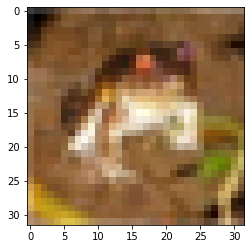

In [7]:
#查看图像
import matplotlib.pyplot as plt
plt.imshow(Xtrain[0])

In [8]:
#显示标签类别
label_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
print(label_dict[Ytrain[0]])

frog


In [9]:
def plot_images_labels_prediction(images,labels,prediction,idx,num = 10):
    fig = plt.gcf()
    fig.set_size_inches(12,6)
    for i in range(num):
        ax = plt.subplot(2,5,1 + i)
        ax.imshow(images[idx])
        title = str(i) + ',' + label_dict[labels[idx]]
        if len(prediction)>0:
            title += label_dict[prediction[idx]]
        ax.set_title(title,fontsize = 10)
        idx += 1
    plt.show()

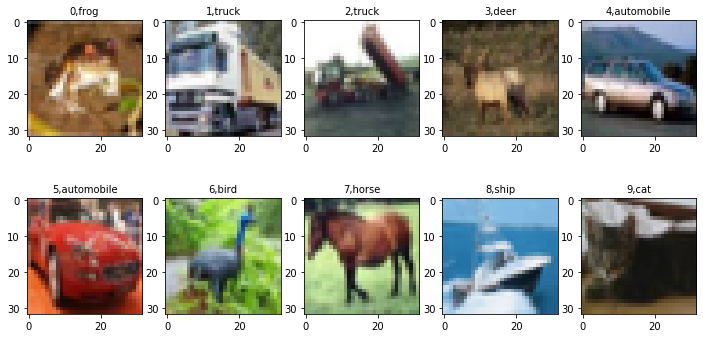

In [10]:
plot_images_labels_prediction(Xtrain,Ytrain,[],0)

In [11]:
from sklearn.preprocessing import OneHotEncoder
#对标签数据进行独热编码
encoder = OneHotEncoder(sparse = False)
yy = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]
encoder.fit(yy)
Ytrain_reshape = Ytrain.reshape(-1,1)
Ytrain_onehot = encoder.transform(Ytrain_reshape)
Ytest_reshape = Ytest.reshape(-1,1)
Ytest_onehot = encoder.transform(Ytest_reshape)
#预处理
Xtrain_normalize = Xtrain.astype('float32')/255.0
Xtest_normalize = Xtest.astype('float32')/255.0

D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [12]:
import tensorflow as tf
#定义权重，卷积核w=[filter的长，filter的宽，input的深度，output的深度]
def weight(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev = 0.1))
#定义偏置
def bias(shape):
    return tf.Variable(tf.zeros(shape))
#定义卷积层
def conv2d(x,filte):
    return tf.nn.conv2d(x,filte,strides = [1,1,1,1],padding = 'SAME')
#定义池化层
def max_pool(x):
    return tf.nn.max_pool(x,ksize = [1,2,2,1],strides = [1,2,2,1],padding = 'SAME')

In [13]:
#定义网络结构
x = tf.placeholder('float',shape = [None,32,32,3])
y = tf.placeholder('float',shape = [None,10])
#定义第一个卷积层 输入3channel 输出为32 ，大小为32x32
filte1 = weight([3,3,3,32])
b1 = bias([32])
conv_1 = conv2d(x,filte1) + b1
conv_1 = tf.nn.relu(conv_1)

#定义第一个池化层,输出图像大小变为16x16
pool_1 = max_pool(conv_1)

#定义第二个卷积层,通道由32变为64
filte2 = weight([3,3,32,64])
b2 = bias([64])
conv_2 = conv2d(pool_1,filte2) + b2
conv_2 = tf.nn.relu(conv_2)

#定义第二个池化层，大小变为8x8
pool_2 = max_pool(conv_2)

#定义全接连层，将64个8x8的图像转变为一维向量，长度为64*8*8 = 4096，并用128个神经元接收
w1 = weight([4096,128])
b3 = bias([128])
f = tf.reshape(pool_2,[-1,4096])
h = tf.nn.relu(tf.matmul(f,w1)+b3)
h_dropout = tf.nn.dropout(h,keep_prob = 0.8)

#定义输出层
w2 = weight([128,10])
b4 = bias([10])
pred = tf.nn.softmax(tf.matmul(h_dropout,w2)+b4)




Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
#定义准确率,1为按行找，0为按列找
correct_prediction = tf.equal(tf.argmax(pred,1),tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,'float'))

#定义损失函数和优化器
loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred,labels = y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss_function)



In [17]:
#启动会话
import os 
from time import time

epoch = 25
batch_size = 50
total_batch = int(len(Xtrain)/batch_size)
epoch_list = []
accuracy_list = []
loss_list = []
epoch_ = tf.Variable(0,name = 'epoch',trainable = False)
startTime = time()
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)


In [19]:
#断点续训
#设置检查点目录
ckpt_dir = 'CIFAR10_log/'
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

#生成saver
saver = tf.train.Saver(max_to_keep=1)

#如果有检查点文件，读取最新的检查点文件，恢复各种变量值
ckpt = tf.train.latest_checkpoint(ckpt_dir)
if ckpt != None:
    saver.restore(sess,ckpt) #加载所以参数
    #之后便可直接使用模型进行预测或者继续训练
else:
    print('training from scratch')

#获取训练参数
start = sess.run(epoch_)
print('training starts from {} epoch'.format(start+1))



    

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from CIFAR10_log/CIFAR10_cnn_model.cpkt-25


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key Variable/Adam_2 not found in checkpoint
	 [[node save/RestoreV2 (defined at <ipython-input-19-2f357a4e99cf>:8) ]]

Caused by op 'save/RestoreV2', defined at:
  File "D:\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "D:\Anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "D:\Anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "D:\Anaconda3\envs\tensorflow\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tornado\gen.py", line 781, in inner
    self.run()
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tornado\gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-2f357a4e99cf>", line 8, in <module>
    saver = tf.train.Saver(max_to_keep=1)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 832, in __init__
    self.build()
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 844, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 881, in _build
    build_save=build_save, build_restore=build_restore)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 513, in _build_internal
    restore_sequentially, reshape)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 332, in _AddRestoreOps
    restore_sequentially)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 580, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 1571, in restore_v2
    name=name)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key Variable/Adam_2 not found in checkpoint
	 [[node save/RestoreV2 (defined at <ipython-input-19-2f357a4e99cf>:8) ]]


In [21]:
#训练
def get_train_batch(number,batch_size):
    return Xtrain_normalize[number*batch_size:(number+1)*batch_size],Ytrain_onehot[number*batch_size:(number+1)*batch_size]
start = 0
for ep in range(start,epoch):
    for i in range(total_batch):
        batch_x,batch_y = get_train_batch(i,batch_size)
        sess.run(optimizer,feed_dict={x:batch_x,y:batch_y})
        if i%100 == 0:
            print('step {}'.format(i),'finished')
    loss,acc = sess.run([loss_function,accuracy],feed_dict={x:batch_x,y:batch_y})
    epoch_list.append(ep+1)
    loss_list.append(loss)
    accuracy_list.append(acc)

    print('train epoch:',ep,'loss=',loss,'accuracy=',acc)

    #保存检查点
    saver.save(sess,ckpt_dir+'CIFAR10_cnn_model.cpkt',global_step = ep + 1)
    sess.run(epoch_.assign(ep+1))

duration = time() - startTime
print('train finished takes',duration)



step 0 finished
step 100 finished
step 200 finished
step 300 finished
step 400 finished
step 500 finished
step 600 finished
step 700 finished
step 800 finished
step 900 finished
train epoch: 0 loss= 2.190138 accuracy= 0.28
step 0 finished
step 100 finished
step 200 finished
step 300 finished
step 400 finished
step 500 finished
step 600 finished
step 700 finished
step 800 finished
step 900 finished
train epoch: 1 loss= 2.1362004 accuracy= 0.3
Instructions for updating:
Use standard file APIs to delete files with this prefix.
step 0 finished
step 100 finished
step 200 finished
step 300 finished
step 400 finished
step 500 finished
step 600 finished
step 700 finished
step 800 finished
step 900 finished
train epoch: 2 loss= 2.1695645 accuracy= 0.26
step 0 finished
step 100 finished
step 200 finished
step 300 finished
step 400 finished
step 500 finished
step 600 finished
step 700 finished
step 800 finished
step 900 finished
train epoch: 3 loss= 2.085915 accuracy= 0.36
step 0 finished
step 10

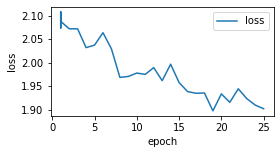

In [27]:
#可视化loss
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(4,2)
plt.plot(epoch_list,loss_list,label = 'loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'],loc='upper right')

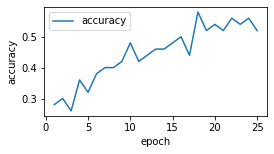

In [22]:
#可视化准确率
plt.plot(epoch_list,accuracy_list,label = 'accuracy')
fig = plt.gcf()
fig.set_size_inches(4,2)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [23]:
#计算测试集准确率
test_total_batch = int(len(Xtest_normalize)/batch_size)
test_acc_sum = 0.0
for i in range(test_total_batch):
    test_image_batch = Xtest_normalize[i*batch_size:(i+1)*batch_size]
    test_label_batch = Ytest_onehot[i*batch_size:(i+1)*batch_size]
    test_batch_acc = sess.run(accuracy,feed_dict = {x:test_image_batch,y:test_label_batch})
    test_acc_sum += test_batch_acc
test_acc = float(test_acc_sum/test_total_batch)
print('test accutacy',test_acc)

test accutacy 0.6325000040233135


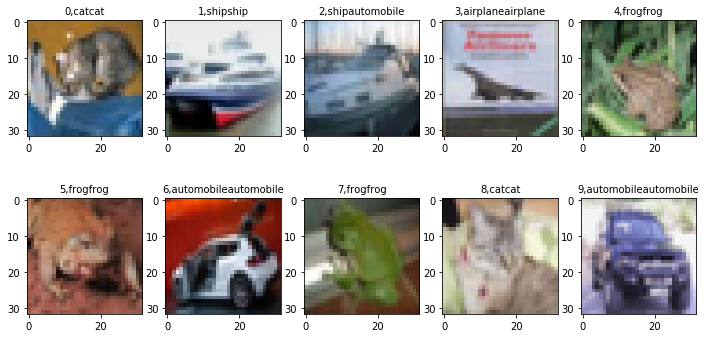

In [24]:
#利用模型进行预测
test_pred = sess.run(pred,feed_dict={x:Xtest_normalize[:10]})
predict_result = sess.run(tf.argmax(test_pred,1))
plot_images_labels_prediction(Xtest,Ytest,predict_result,0,10)